# Aaron's (minimal) example of using Firefly with Gaia data


## Download the Gaia data 

In [4]:
import numpy as np
from scipy.signal import find_peaks

from astroquery.gaia import Gaia

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

Retrieve all the available data in the region of interest.

I will download data in the direction of the open cluster M67 (coordinates: RA = 132.825 deg, +11.8167) with a search radius of 1 degrees.

I will perform an asynchronous query (asynchronous rather than synchronous queries should be performed when retrieving more than 2000 rows), and also require that the parallax and proper motion data to be well behaved (to remove likely spurious data).

Note: The query to the archive is with ADQL (Astronomical Data Query Language). For a description of ADQL and more examples see the Gaia DR1 ADQL cookbook: https://gaia.ac.uk/data/gaia-data-release-1/adql-cookbook

In [ ]:
cmd = "SELECT * FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec),\
    CIRCLE('ICRS', 132.825, 11.8167, 1))=1\
    AND parallax>0 \
    AND abs(pmra_error)<5 \
    AND abs(pmdec_error)<5 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0;"

job = Gaia.launch_job_async(cmd, dump_to_file=False) #could save this to a file

print (job)

This downloads as an astropy table.  Save this to an [ecsv](https://docs.astropy.org/en/stable/io/ascii/ecsv.html) file (to retain the units and masks).  That way I can reuse this data later without having to download from Gaia

In [24]:
tab = job.get_results()
tab.write('Gaia_m67.ecsv', overwrite=True)

In [2]:
# to read the data back in
# tab = Table.read('Gaia_m67.ecsv')

Calculate 3D coordinates

In [7]:
coords_3d = SkyCoord(
    ra=tab['ra'], 
    dec=tab['dec'],
    distance=Distance(parallax=tab['parallax'])
)
coords_3d.cartesian

<CartesianRepresentation (x, y, z) in pc
    [( -535.63275304,  574.10612437, 152.0525518 ),
     (-1335.97797743, 1447.60707761, 377.26715435),
     ( -410.37740413,  441.35121011, 115.28175694), ...,
     (-2136.63687143, 2351.45864835, 689.0954773 ),
     ( -894.40505543,  983.846021  , 288.60824299),
     ( -757.80800397,  833.84958406, 244.52586334)]>

Do the same for the expected cluster center (from literature/internet)

In [8]:
coords_3d_center = SkyCoord(
    ra=132.825*u.deg, 
    dec=11.8167*u.deg,
    distance=900*u.parsec
)

I prefer pandas (and so does Firefly), though note that this will remove the units.  Let's also simply things to only continue with the columns we're interested in.

In [9]:
# look at all the column names
list(tab.columns)

['solution_id',
 'DESIGNATION',
 'SOURCE_ID',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

In [10]:
cols = [
    'SOURCE_ID',
    'ra',
    'dec',
    'parallax',
    'pmra',
    'pmdec',
    'radial_velocity',
    'phot_g_mean_mag',
    'bp_rp',
    'ruwe',
    'teff_gspphot'
]
df = tab[cols].to_pandas()

# add the 3D coordinates but center them on the expected cluster center
df['x'] = coords_3d.cartesian.x - coords_3d_center.cartesian.x
df['y'] = coords_3d.cartesian.y - coords_3d_center.cartesian.y
df['z'] = coords_3d.cartesian.z - coords_3d_center.cartesian.z

df

,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_rp,ruwe,teff_gspphot,x,y,z
0,598665153403811584,133.014416,10.959910,1.250371,4.593960,0.298346,NaN,19.100042,2.131905,1.034447,NaN,63.187387,-71.995078,-32.250666
1,598642613415506816,132.703519,10.841912,0.498585,-1.324554,-9.762845,NaN,19.215780,1.555378,0.963662,NaN,-737.157837,801.505875,192.963936
2,598615293128513664,132.917310,10.829167,1.629758,-13.061099,-4.312267,NaN,19.435879,2.302393,1.051654,NaN,188.442736,-204.749992,-69.021461
3,598615464927206656,132.972266,10.832058,1.741781,-2.927386,-1.576951,NaN,20.715143,0.905416,0.990248,NaN,214.443996,-233.508031,-76.407376
4,598615464931821824,132.980100,10.828845,1.426034,-2.331372,-4.489130,NaN,19.728138,2.187979,1.067665,NaN,129.262929,-142.211982,-52.556095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14906,607990210302605952,132.276677,12.231637,0.505344,-2.126364,-3.552206,NaN,18.926622,1.714691,1.015449,3835.843506,-702.155275,784.821826,234.944723
14907,607990248958012672,132.286291,12.234218,0.338400,-5.845476,-3.210716,NaN,20.020117,2.443151,1.026784,NaN,-1344.306894,1490.394250,441.903035
14908,607990283317791232,132.259641,12.237231,0.307591,1.553191,-4.156176,NaN,19.274897,0.988407,1.044939,NaN,-1537.816731,1705.357446,504.792259
14909,607990313381861376,132.273676,12.246604,0.734975,-1.931631,1.440591,NaN,20.155001,1.702597,1.012051,NaN,-295.584915,337.744819,104.305025


Possibly make a selection so that we have an additional group of only members.  (This is a rather crude estimate.)

In [11]:
def find_gaia_peak(arr, bins=100, range=[-20,20], return_plot = False):

    # calculate the histogram and find the most prominent peak (using scipy)
    heights, bin_edges = np.histogram(arr, bins=bins, range=range)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges)
    pk,dct = find_peaks(heights, prominence=(None,None))
    pk = pk[dct['prominences'].argsort()[::-1]]

    peak = bin_centers[pk[0]]
    out = {'peak':peak}

    if (return_plot):
        f, ax = plt.subplots()
        ax.step(bin_centers, heights, where='mid', color='black')
        ax.axvline(peak, color='firebrick')
        out['f'] = f
        out['ax'] = ax
    
    return out

np.float64(-10.799999999999999)

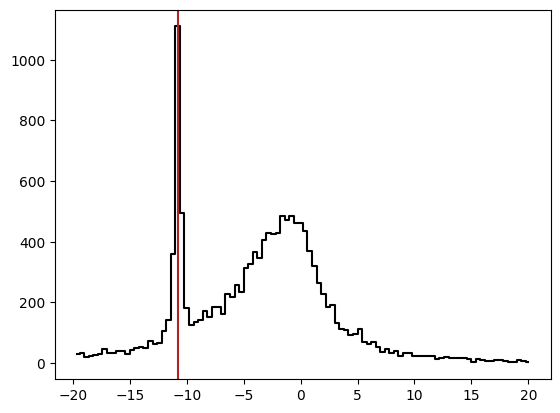

In [13]:
dct = find_gaia_peak(df['pmra'], bins=100, range=[-20,20], return_plot = True)
dct['peak']

In [14]:
# I just used a guess-and-check method to settle on the numbers here
members = df.loc[
    (abs(df['parallax'] - find_gaia_peak(df['parallax'], bins=100, range=[0,5])['peak']) < 5) & 
    (abs(df['pmra'] - find_gaia_peak(df['pmra'], bins=100, range=[-20,20])['peak']) < 0.25) &
    (abs(df['pmdec'] - find_gaia_peak(df['pmdec'], bins=100, range=[-20,20])['peak']) < 0.25)
]
members

,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_rp,ruwe,teff_gspphot,x,y,z
31,598616706172696320,133.137319,10.889397,1.163956,-10.972590,-2.912316,NaN,18.941805,2.325441,1.033516,3401.620361,21.962248,-30.461647,-22.000128
162,598623990437231872,133.083812,10.967168,1.056753,-10.684455,-2.573730,NaN,15.091007,0.952922,0.996579,5464.710938,-35.757975,32.407916,-4.273897
178,598624402754072576,133.170090,11.004250,1.386472,-10.800401,-2.978671,NaN,18.824274,2.328720,1.061183,3566.376953,114.434826,-129.743327,-46.628754
316,598644224028050432,132.692924,10.914530,1.432365,-10.730201,-2.906784,NaN,18.584200,2.169525,1.006188,3584.736084,133.992182,-142.247124,-52.113089
416,598656902771538688,132.569805,10.961873,0.719661,-10.983169,-2.738798,NaN,18.778568,2.246220,1.070116,3371.409668,-324.038016,358.561620,79.926496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14377,605107462613473792,133.249881,12.505000,0.676841,-10.717909,-2.972463,NaN,18.597679,1.445206,1.053434,4302.688965,-389.486897,404.504489,135.601634
14388,605107810506158848,133.221563,12.533796,1.150784,-10.974195,-2.929130,NaN,15.166164,0.987417,1.052786,5360.221191,17.910888,-27.962035,4.277363
14564,605119694680355072,133.053553,12.564901,1.109576,-10.899552,-2.834700,NaN,18.831617,2.170263,0.993078,3544.833496,-1.707716,-3.319491,11.758408
14830,607987427163771520,132.122303,12.109806,1.122718,-10.852459,-2.812150,35.607601,13.352934,0.736095,0.911993,6066.637207,14.710440,-0.159832,2.552243


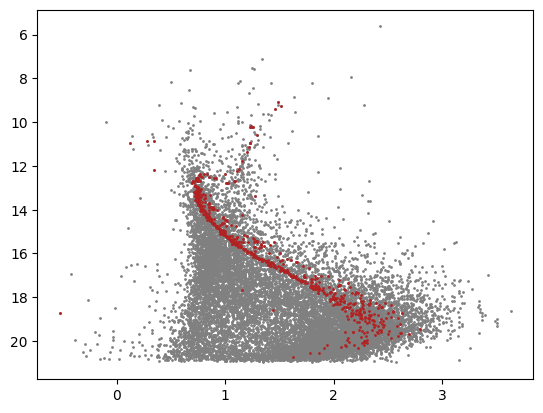

In [15]:
# check the CMD
f, ax = plt.subplots()
ax.scatter(df['bp_rp'],df['phot_g_mean_mag'], s=1, color='gray')
ax.scatter(members['bp_rp'],members['phot_g_mean_mag'], s=1, color='firebrick')

plt.gca().invert_yaxis()

## Format Data for Firefly

In [16]:
coords_all = df[['x','y','z']].to_numpy()
coords_members = members[['x','y','z']].to_numpy()
coords = [coords_all, coords_members]

In [17]:
field_names = ['SOURCE_ID','parallax','pmra','pmdec','radial_velocity','phot_g_mean_mag','bp_rp','teff_gspphot','ruwe']
fields_all = np.nan_to_num(df[field_names], nan=-999)
fields_members = np.nan_to_num(members[field_names], nan=-999)
fields = [fields_all, fields_members]

Here are the [docs for ArrayReader](https://firefly.rcs.northwestern.edu/docs/reference/api/readers/firefly.data_reader.ArrayReader.html).

In [18]:
from firefly.data_reader import ArrayReader

In [19]:
my_arrayReader = ArrayReader(
    coords,
    fields=fields,
    field_names=field_names,
    UInames=['all','members'],
    write_to_disk=False)

datadir is None, defaulting to /home/ageller/miniforge3/envs/firefly-wsl/lib/python3.11/site-packages/firefly/static/data/Data


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Display Inline

In [50]:
from firefly.server import spawnFireflyServer,quitAllFireflyServers

In [51]:
# define the local port (typically anything in 5000 - 8000 range)
port = 5500

In [ ]:
process = spawnFireflyServer(port, method = 'flask')

In [ ]:
from IPython.display import IFrame
url = f'http://localhost:{port:d}/combined'
IFrame(url, width=1000, height=500)

In [ ]:
# Send data to the server.
# Wait until it loads to run this command
my_arrayReader.sendDataViaFlask()

## Get the selected data in Python

(after using the selection tool)

In [10]:
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# send a get request to receive the current settings from Firefly
# for larger amounts of data, you will need to increase the waitTime (in seconds) via params (see below; the default is 10s)
r = requests.get(url = f'http://localhost:{port:d}/get_selected_data', params = {'waitTime':60})
if r.status_code == 200:
    # success
    selection = r.json()
    # as a check
    partsKeys = list(selection.keys())
    print(partsKeys[0])
    print(selection[partsKeys[0]]['Coordinates_flat'][:100]) 
else:
    print('Error: {}'.format(r.status_code), r.content)


In [ ]:
# plot x, y for the selected points
partsKeys = list(selection.keys())
part0 = selection[partsKeys[0]]

# UPDATE THIS
x = part0['Coordinates_flat'][0::3]
y = part0['Coordinates_flat'][1::3]

f, ax = plt.subplots()
ax.scatter(x[:1000],y[:1000])

### Quit the Firefly server

... this doesn't always work in a notebook ... you can also quit the server by resetting the kernel.

In [ ]:
return_code = quitAllFireflyServers()